In [27]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
import math
import time
import tensorflow.keras as keras
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing #数据标准化处理
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential #序贯式模型 
from tensorflow.keras.layers import Dense, Dropout, Layer
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import proplot as pplt
from sklearn.preprocessing import StandardScaler

import mdn

In [2]:
SEED = 123

In [3]:
# set figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 7.2, 5.4

# calculagraph
def helper_print_with_time(*arg,sep=','):
    print(time.strftime("%H:%M:%S",time.localtime()),sep.join(map(str,arg)))

In [4]:
def plot_loss(h, nb_epoch, savefig=False, figname=None):
    """
    Given DNN model, plot accuracy and loss curve
    
    :h: a fitted model such as 
        h = model.fit(x_train,y_train,...)
    :nb_epoch: the number of epoch
    :savefig: save the plot figure as 'eps' image format, default: False
    :return
    """
    loss, val_loss = [
        h.history['loss'],
        h.history['val_loss'], 
        
        ]
    fig, axs = plt.subplots()
    
    axs.plot(range(nb_epoch), loss, lw=0.5, color='dodgerblue', label='Train')
    axs.plot(range(nb_epoch), val_loss, lw=0.5, color='brown', label='Test')
    #axs[0].set_title('Accuracy over ' + str(nb_epoch) + ' Epochs', size=15)
    axs.legend()
    #plt.grid(linestyle='-.')
    
    # axs[1].plot(range(nb_epoch), m_dilute_loss, lw=0.5, color='dodgerblue', label='m_dilute_Train')
    # axs[1].plot(range(nb_epoch), val_m_dilute_loss, lw=0.5, color='brown', label='m_dilute_Test')
    # axs[1].plot(range(nb_epoch), core_mass_loss, lw=0.5, color='blue', label='core_mass_Train')
    # axs[1].plot(range(nb_epoch), val_core_mass_loss, lw=0.5, color='red', label='vore_mass_Test')
    # #axs[1].set_title('Loss over ' + str(nb_epoch) + ' Epochs', size=15)
    # axs[1].legend()
    
    #axs[0].set_ylim(ymax=100)
    #axs[1].set_ylim(ymin=0)
    #axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    #axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # Only draw spine between the y-ticks
    #axs[0].spines['left'].set_bounds(-1, 1)
    #axs[1].spines['left'].set_bounds(-1, 1)
    # Hide the right and top spines
    axs.spines['right'].set_visible(False)
    # axs[1].spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    # axs[1].spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    axs.yaxis.set_ticks_position('left')
    # axs[1].yaxis.set_ticks_position('left')
    axs.xaxis.set_ticks_position('bottom')
    # axs[1].xaxis.set_ticks_position('bottom')
    
    axs.tick_params(labelsize=13)
    # axs[1].tick_params(labelsize=13)
    #plt.grid(linestyle='-.')
    # if savefig:
        # plt.savefig(str(figname)+'loss.eps')
    #plt.savefig(str(nb_epoch)+'_'+str(batch_size)+'_'+str(loss_function)+'_'+str(op_name)+'_'+str(learning_rate)+'.jpg', dpi=300)
    plt.show()
    

In [5]:
df_GG = pd.read_excel('D:\\Resource\\Gas_Giants_Core_Earth20W.xlsx')

In [6]:
df_GG.columns

Index(['Mass (M_J)', 'Radius (R_E)', 'Period (d)', 'Mcore (M_J/10^3)',
       'Menv (M_E)', 'T_sur (K)', 'T_int (K)', 'T_eff (K)', 'P_CEB (Mbar)',
       'T_CEB (K)', 'M_J=317.83 M_E'],
      dtype='object')

In [7]:
df_GG['M_total (M_E)'] = df_GG['Mcore (M_J/10^3)'] + df_GG['Menv (M_E)']

# Input = (M, R, T_sur)
### N_HIDDEN=512
### testing data=0.1
### validation_split=0.1
### dropout=0.05
### batchsize=256

In [8]:
input_parameters = [
    'Mass (M_J)', 
    'Radius (R_E)',
    'T_sur (K)',
]

output_parameters = [
    'M_total (M_E)',
    'T_int (K)',
    'P_CEB (Mbar)',
    'T_CEB (K)'
]

X = df_GG[input_parameters]

y = df_GG.loc[:, output_parameters]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)

scaler_x = MinMaxScaler().fit(X_train)
scaler_y = MinMaxScaler().fit(y_train)

# from pickle import dump
# save the scaler
# dump(scaler, open('scaler.pkl', 'wb'))
X_train_scaled = scaler_x.transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.transform(y_train)
y_test_scaled = scaler_y.transform(y_test)



N_HIDDEN, N_MIXES = 512, 20  # N_MIXES is the number of mixtures
DROP_PROB = 0.05
INPUT_DIMS = len(input_parameters)               
OUTPUT_DIMS = len(output_parameters)



early_stopping = EarlyStopping(monitor='val_loss',
                mode='min',
                patience=30, 
                verbose=1,
                )
model = keras.Sequential()
model.add(Dense(N_HIDDEN, batch_input_shape=(None, INPUT_DIMS), activation='relu'))
model.add(Dropout(DROP_PROB))
model.add(Dense(N_HIDDEN, activation='relu'))
model.add(Dropout(DROP_PROB))
model.add(Dense(N_HIDDEN, activation='relu'))
model.add(Dropout(DROP_PROB))
# model.add(Dense(N_HIDDEN, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(N_HIDDEN, activation='relu'))
# model.add(Dropout(0.5))
model.add(mdn.MDN(OUTPUT_DIMS, N_MIXES, name='mdn_outputs'))
model.summary()



# plot_model(
#     model, 
#     to_file='model.png', 
#     show_shapes=True
# )

# model = multi_gpu_model(model, 1)
model.compile(
    loss=mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES),
    # metrics=[mdn.get_mixture_mse_accuracy(OUTPUT_DIMS,N_MIXES)],
    optimizer=keras.optimizers.Adam(learning_rate=0.001)
)
history=model.fit(
    X_train_scaled,y_train_scaled,
    epochs=200,
    batch_size=256,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
mdn_outputs (MDN)            (None, 180)               9

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


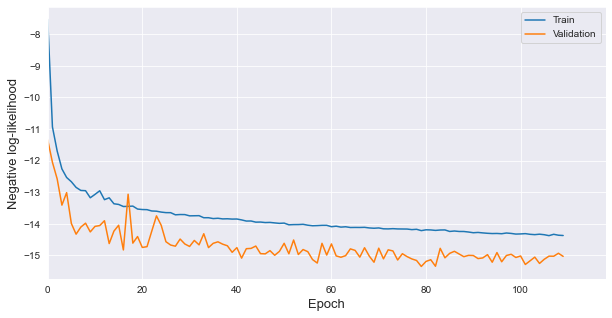

In [11]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Negative log-likelihood', fontsize=13)
plt.legend()
plt.xlim(0, 118)
# plt.ylim(-20, -6)
plt.savefig('GasGiants_MDN20210831_loss.eps')

In [45]:
pred = model.predict(X_test_scaled)

In [42]:
y_pred = tf.reshape(pred, [-1, (2 * N_MIXES * OUTPUT_DIMS) + N_MIXES], name='reshape_ypreds')

In [40]:
pred = tf.reshape(pred, [-1, (2 * N_MIXES * OUTPUT_DIMS) + N_MIXES], name='reshape_ypreds')
out_mu, out_sigma, out_pi = tf.split(pred, num_or_size_splits=[N_MIXES * OUTPUT_DIMS,
                                                                         N_MIXES * OUTPUT_DIMS,
                                                                         N_MIXES], axis=1, name='mdn_coef_split')

In [22]:
out_mu_1 = tf.reshape(out_mu, (len(out_mu), N_MIXES, OUTPUT_DIMS)).numpy()
out_sigma_1 = tf.reshape(out_sigma, (len(out_sigma), N_MIXES, OUTPUT_DIMS)).numpy()
pis_np = out_pi.numpy()

In [28]:
idx = np.arange(N_MIXES)

In [35]:
to_choose_from = np.arange(N_MIXES)
samples = np.zeros((out_mu_1.shape[0], 1))
for j, (weights, means, std_devs) in enumerate(
      zip(pis_np, out_mu_1, out_sigma_1)):
    index = np.random.choice(to_choose_from, p=np.exp(weights))
    samples[j, 0] = np.random.normal(means[index], std_devs[index], size=1)
    #samples[j, 0] = x[j]
    if j == out_mu_1.shape[0] - 1:
      break

ValueError: probabilities do not sum to 1

In [44]:
sample_function = mdn.get_mixture_sampling_fun(OUTPUT_DIMS, N_MIXES)

In [46]:
samples = sample_function(pred)

In [13]:
from sklearn.metrics import r2_score

In [49]:
r2_score(y_test_scaled, samples)

0.9807992374521515

AttributeError: 'Figure' object has no attribute 'save'

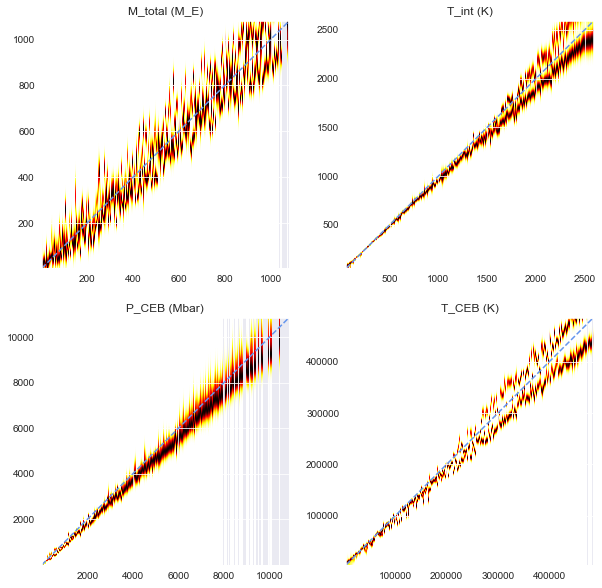

In [9]:
pred = model.predict(X_test_scaled)
# pred contains parameters for distributions, not actual points on the graph.
# To find points on the graph, we need to sample from each distribution.

# Split up the mixture parameters
mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, pred)
sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, pred)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred)

y_label = np.arange(0,1,0.001).reshape(-1,1)
cmap = plt.cm.hot_r
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
fig = plt.figure(figsize=(10,10))
# fig.subplots_adjust(hspace=0.2, wspace=0.4)
# ax = plt.gca()
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
x_tickrange = [
    np.arange(0, 1100, 100),
    np.arange(100, 3600, 500),
#     np.arange(100, 2700, 100),
    np.arange(0, 14000, 2000),
    np.arange(0, 600000, 100000),
]
xminrange = [
    0, 
    0, 
    0, 
    0
]
xmaxrange = [
    1000, 
    3000, 
    12000,
    500000
]

for img_num in range(OUTPUT_DIMS):
    ax = fig.add_subplot(2, 2, img_num+1)
    y_max = max(y_test[output_parameters[img_num]])
    y_min = min(y_test[output_parameters[img_num]])
    for c in range(len(y_test_scaled)):
        for m in range(OUTPUT_DIMS):
            locals()['mus'+str(m)] = []
            locals()['sigs'+str(m)] = []
            for n in range(20):
                locals()['mus'+str(m)].append(mus[c][n*OUTPUT_DIMS + m])
                locals()['sigs'+str(m)].append(sigs[c][n*OUTPUT_DIMS + m])
        i = img_num
        mus_ = np.array(locals()['mus'+str(i)])
        sigs_ = np.array(locals()['sigs'+str(i)])
        factors = 1 / math.sqrt(2*math.pi) / sigs_
        exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
        GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1); # 对多个高斯分布求和
        MM = MinMaxScaler()
        GMM_PDF_scaled = MM.fit_transform(GMM_PDF.reshape(-1, 1))
        tx, ty = [y_test.values[c,i],y_min]
        ax.imshow(
            GMM_PDF_scaled.reshape(-1, 1),
            cmap=cmap, 
            norm=norm, 
            origin='lower', 
            extent=(tx, tx + 0.0001, ty, y_max)
        )
    ax.plot([y_min, y_max], [y_min, y_max], c='cornflowerblue', ls='--')
    plt.axis('square')
    ax.set_xlim(y_min, y_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(output_parameters[img_num])
#     ax.xaxis.set_ticks(x_tickrange[img_num])
#     ax.yaxis.set_ticks(x_tickrange[img_num])
#     plt.savefig(output_parameters[img_num] + '_water.pdf')
# plt.show()
plt.savefig('GasGiants_MDN20210831_prediction.eps')



In [11]:
fig.save('D:\\PythonProject\\RebuildProject\\Rock\\imgs\\prediction_GasGiantExoplanetTensorflow_20240507.jpg')

AttributeError: 'Figure' object has no attribute 'save'

In [27]:
model.save("GasGiants_MDN20210831.h5")
# Save scaler
from sklearn.externals import joblib
joblib.dump(scaler_x, "MDN_INPUT_scaler20210831.save") 
joblib.dump(scaler_y, "MDN_OUTPUT_scaler20210831.save")

C:\Users\zy\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['MDN_OUTPUT_scaler20210831.save']

# Input = (M, R)

### N_HIDDEN=512
### testing data=0.1
### validation_split=0.1
### dropout=0.1
### batchsize=256

In [7]:
input_parameters = [
    'Mass (M_J)', 
    'Radius (R_E)',
]

output_parameters = [
    'M_total (M_E)',
    'T_int (K)', 
    'P_CEB (Mbar)',
    'T_CEB (K)'
]

X = df_GG[input_parameters]

y = df_GG.loc[:, output_parameters]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)

scaler_x = MinMaxScaler().fit(X_train)
scaler_y = MinMaxScaler().fit(y_train)

# from pickle import dump
# save the scaler
# dump(scaler, open('scaler.pkl', 'wb'))
X_train_scaled = scaler_x.transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.transform(y_train)
y_test_scaled = scaler_y.transform(y_test)





N_HIDDEN, N_MIXES = 512, 20  # N_MIXES is the number of mixtures
DROP_PROB = 0.05
INPUT_DIMS = len(input_parameters)               
OUTPUT_DIMS = len(output_parameters)



early_stopping = EarlyStopping(monitor='val_loss',
                mode='min',
                patience=30, 
                verbose=1,
                )
model = keras.Sequential()
model.add(Dense(N_HIDDEN, batch_input_shape=(None, INPUT_DIMS), activation='relu'))
model.add(Dropout(DROP_PROB))
model.add(Dense(N_HIDDEN, activation='relu'))
model.add(Dropout(DROP_PROB))
model.add(Dense(N_HIDDEN, activation='relu'))
model.add(Dropout(DROP_PROB))
# model.add(Dense(N_HIDDEN, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(N_HIDDEN, activation='relu'))
# model.add(Dropout(0.5))
model.add(mdn.MDN(OUTPUT_DIMS, N_MIXES, name='mdn_outputs'))
model.summary()



# plot_model(
#     model, 
#     to_file='model.png', 
#     show_shapes=True
# )

helper_print_with_time('>>>begin')
# model = multi_gpu_model(model, 1)
model.compile(
    loss=mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES),
    # metrics=[mdn.get_mixture_mse_accuracy(OUTPUT_DIMS,N_MIXES)],
    optimizer=keras.optimizers.Adam(lr=0.001)
)
history=model.fit(
    X_train_scaled,y_train_scaled,
    epochs=200,
    batch_size=256,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=0)
helper_print_with_time('>>>end')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1536      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
mdn_outputs (MDN)            (None, 180)               9

(-13, -6)

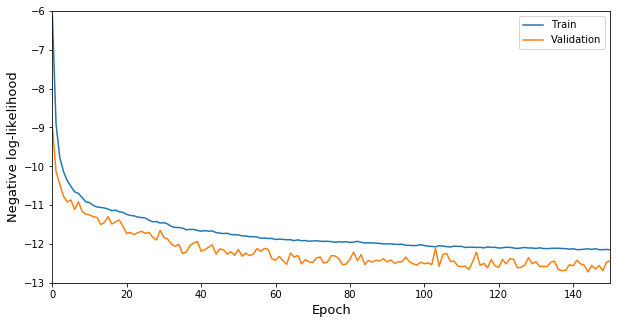

In [8]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Negative log-likelihood', fontsize=13)
plt.legend()
plt.xlim(0, 150)
plt.ylim(-13, -6)
# plt.savefig('MRinput_loss20210909.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


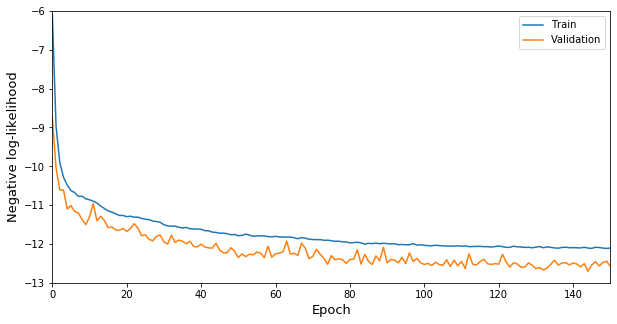

In [11]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Negative log-likelihood', fontsize=13)
plt.legend()
plt.xlim(0, 150)
plt.ylim(-13, -6)
plt.savefig('MRinput_loss20210909.eps')

In [ ]:
pred = model.predict(X_test_scaled)
# pred contains parameters for distributions, not actual points on the graph.
# To find points on the graph, we need to sample from each distribution.

# Split up the mixture parameters
mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, pred)
sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, pred)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred)

y_label = np.arange(0,1,0.001).reshape(-1,1)
cmap = plt.cm.hot_r
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
fig = plt.figure(figsize=(10,10))
# fig.subplots_adjust(hspace=0.2, wspace=0.4)
# ax = plt.gca()
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
x_tickrange = [
    np.arange(0, 1100, 100),
    np.arange(100, 3600, 500),
#     np.arange(100, 2700, 100),
    np.arange(0, 14000, 2000),
    np.arange(0, 600000, 100000),
]
xminrange = [
    0, 
    0, 
    0, 
    0
]
xmaxrange = [
    100, 
    500, 
    100,
    50000
]

for img_num in range(OUTPUT_DIMS):
    ax = fig.add_subplot(2, 2, img_num+1)
    y_max = max(y_test[output_parameters[img_num]])
    y_min = min(y_test[output_parameters[img_num]])
    for c in range(len(y_test_scaled)):
        for m in range(OUTPUT_DIMS):
            locals()['mus'+str(m)] = []
            locals()['sigs'+str(m)] = []
            for n in range(20):
                locals()['mus'+str(m)].append(mus[c][n*OUTPUT_DIMS + m])
                locals()['sigs'+str(m)].append(sigs[c][n*OUTPUT_DIMS + m])
        i = img_num
        mus_ = np.array(locals()['mus'+str(i)])
        sigs_ = np.array(locals()['sigs'+str(i)])
        factors = 1 / math.sqrt(2*math.pi) / sigs_
        exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
        GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1); # 对多个高斯分布求和
        MM = MinMaxScaler()
        GMM_PDF_scaled = MM.fit_transform(GMM_PDF.reshape(-1, 1))
        tx, ty = [y_test.values[c,i],y_min]
        ax.imshow(
            GMM_PDF_scaled.reshape(-1, 1),
            cmap=cmap, 
            norm=norm, 
            origin='lower', 
            extent=(tx, tx + 0.0001, ty, y_max)
        )
    ax.plot([y_min, y_max], [y_min, y_max], c='cornflowerblue', ls='--')
    plt.axis('square')
    ax.set_xlim(y_min, xmaxrange[img_num])
    ax.set_ylim(y_min, xmaxrange[img_num])
    ax.set_title(output_parameters[img_num])
#     ax.xaxis.set_ticks(x_tickrange[img_num])
#     ax.yaxis.set_ticks(x_tickrange[img_num])
#     plt.savefig(output_parameters[img_num] + '_water.pdf')
# plt.show()
plt.savefig('MRinputPreSubFig.pdf.pdf')

In [37]:
model.save("D:\\Resource\\MDN\\TensorflowVersion\\MR_MDN20210924.h5")
# Save scaler

joblib.dump(scaler_x, "D:\\Resource\\MDN\\TensorflowVersion\\MR_INPUT_scaler20210924.save")
joblib.dump(scaler_y, "D:\\Resource\\MDN\\TensorflowVersion\\MR_OUTPUT_scaler20210924.save")

['D:\\Resource\\MDN\\TensorflowVersion\\MR_OUTPUT_scaler20210924.save']

In [39]:
np.save('D:\\Resource\\MDN\\TensorflowVersion\\X_test_scaled.npy', X_test_scaled)
np.save('D:\\Resource\\MDN\\TensorflowVersion\\y_test_scaled.npy', y_test_scaled)

In [2]:
N_HIDDEN, N_MIXES = 512, 20  # N_MIXES is the number of mixtures
DROP_PROB = 0.05
INPUT_DIMS = 3
OUTPUT_DIMS = 4
batch_size = 512

In [3]:
m_2 = keras.models.load_model('D:\\Resource\\MDN\\TensorflowVersion\\MR_MDN20210924.h5', custom_objects={'MDN': mdn.MDN, 'mdn_loss_func': mdn.get_mixture_loss_func(1, N_MIXES)})

In [4]:
y_test_scaled = np.load('D:\\Resource\\MDN\\TensorflowVersion\\y_test_scaled.npy')
X_test_scaled = np.load('D:\\Resource\\MDN\\TensorflowVersion\\X_test_scaled.npy')
m_y = joblib.load("D:\\Resource\\MDN\\TensorflowVersion\\MR_OUTPUT_scaler20210924.save")

In [5]:
mse_function = mdn.get_mixture_mse_accuracy(OUTPUT_DIMS, N_MIXES)
c = mdn.get_mixture_loss_func(OUTPUT_DIMS, N_MIXES)
sample_function = mdn.get_mixture_sampling_fun(OUTPUT_DIMS, N_MIXES)

In [6]:
pred = m_2.predict(X_test_scaled)

In [7]:
samples = sample_function(pred)

In [8]:
print("r2 score: {}, MSE: {}, NLLLoss: {}".format(r2_score(y_test_scaled, samples), np.mean(mse_function(y_test_scaled.astype('float32'), pred)), np.mean(c(y_test_scaled.astype('float32'), pred))))

r2 score: 0.9811911558546873, MSE: 0.0007114006439223886, NLLLoss: -15.043587684631348


In [9]:
input_parameters = [
    'Mass (M_J)',
    'Radius (R_E)',
]

output_parameters = [
    'M_total (M_E)',
    'T_int (K)',
    'P_CEB (Mbar)',
    'T_CEB (K)'
]

In [10]:
# Split up the mixture parameters
mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, pred)
sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, pred)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred)

In [21]:
mu = mus.reshape(mus.shape[0], N_MIXES, int(mus.shape[1] / N_MIXES))
sig = sigs.reshape(sigs.shape[0], N_MIXES, int(sigs.shape[1] / N_MIXES))

In [16]:
y_label = np.arange(0, 1, 0.01).reshape(-1, 1)
y_label_ = y_label[:, np.newaxis, np.newaxis, :]

mu_sub_T = np.transpose(mu, (0, 2, 1))
sigma_sub_T = np.transpose(sig, (0, 2, 1))
# Example: shape(1000, 6, 100, 10) 1000 data, 6 type, 100 rows with 10 columns every type
exponent = np.exp(
    -1 / 2 * np.square(np.transpose((y_label_ - mu_sub_T), (1, 2, 0, 3)) / sigma_sub_T[:, :, np.newaxis, :]))
factors = 1 / math.sqrt(2 * math.pi) / sigma_sub_T[:, :, np.newaxis, :]
GMM_PDF = np.sum(pis[:, np.newaxis, np.newaxis, :] * factors * exponent, axis=-1)
MM = MinMaxScaler()
GMM_PDF = GMM_PDF.reshape(GMM_PDF.shape[0] * GMM_PDF.shape[1], GMM_PDF.shape[-1]).transpose((-1, 0))
# f = e.transpose((-1, 0))
GMM_PDF_scaled = MM.fit_transform(GMM_PDF)

In [25]:
def calculate_GMM(p, m, s):
    y_label = np.arange(0,1,0.01).reshape(-1,1)
    y_label_ = y_label[:, np.newaxis, np.newaxis, :]
    
    mu_sub_T = np.transpose(m, (0, 2, 1))
    sigma_sub_T = np.transpose(s, (0, 2, 1))
    
    # shape(1000, 6, 100, 10) 1000 data, 6 type, 100 rows with 10 columns every type
    exponent = np.exp(-1/2*np.square(np.transpose((y_label_ - mu_sub_T), (1, 2, 0, 3))/sigma_sub_T[:, :, np.newaxis, :]))
    factors = 1 / math.sqrt(2*math.pi) / sigma_sub_T[:, :, np.newaxis, :]
    GMM_PDF = np.sum(p[:, np.newaxis, np.newaxis, :]*factors*exponent, axis=-1)
    MM = MinMaxScaler()
    GMM_PDF = GMM_PDF.reshape(GMM_PDF.shape[0] * GMM_PDF.shape[1], GMM_PDF.shape[-1]).transpose((-1, 0))
    # f = e.transpose((-1, 0))
    return MM.fit_transform(GMM_PDF)

In [26]:
GMM_scaled = calculate_GMM(pis, mu, sig)

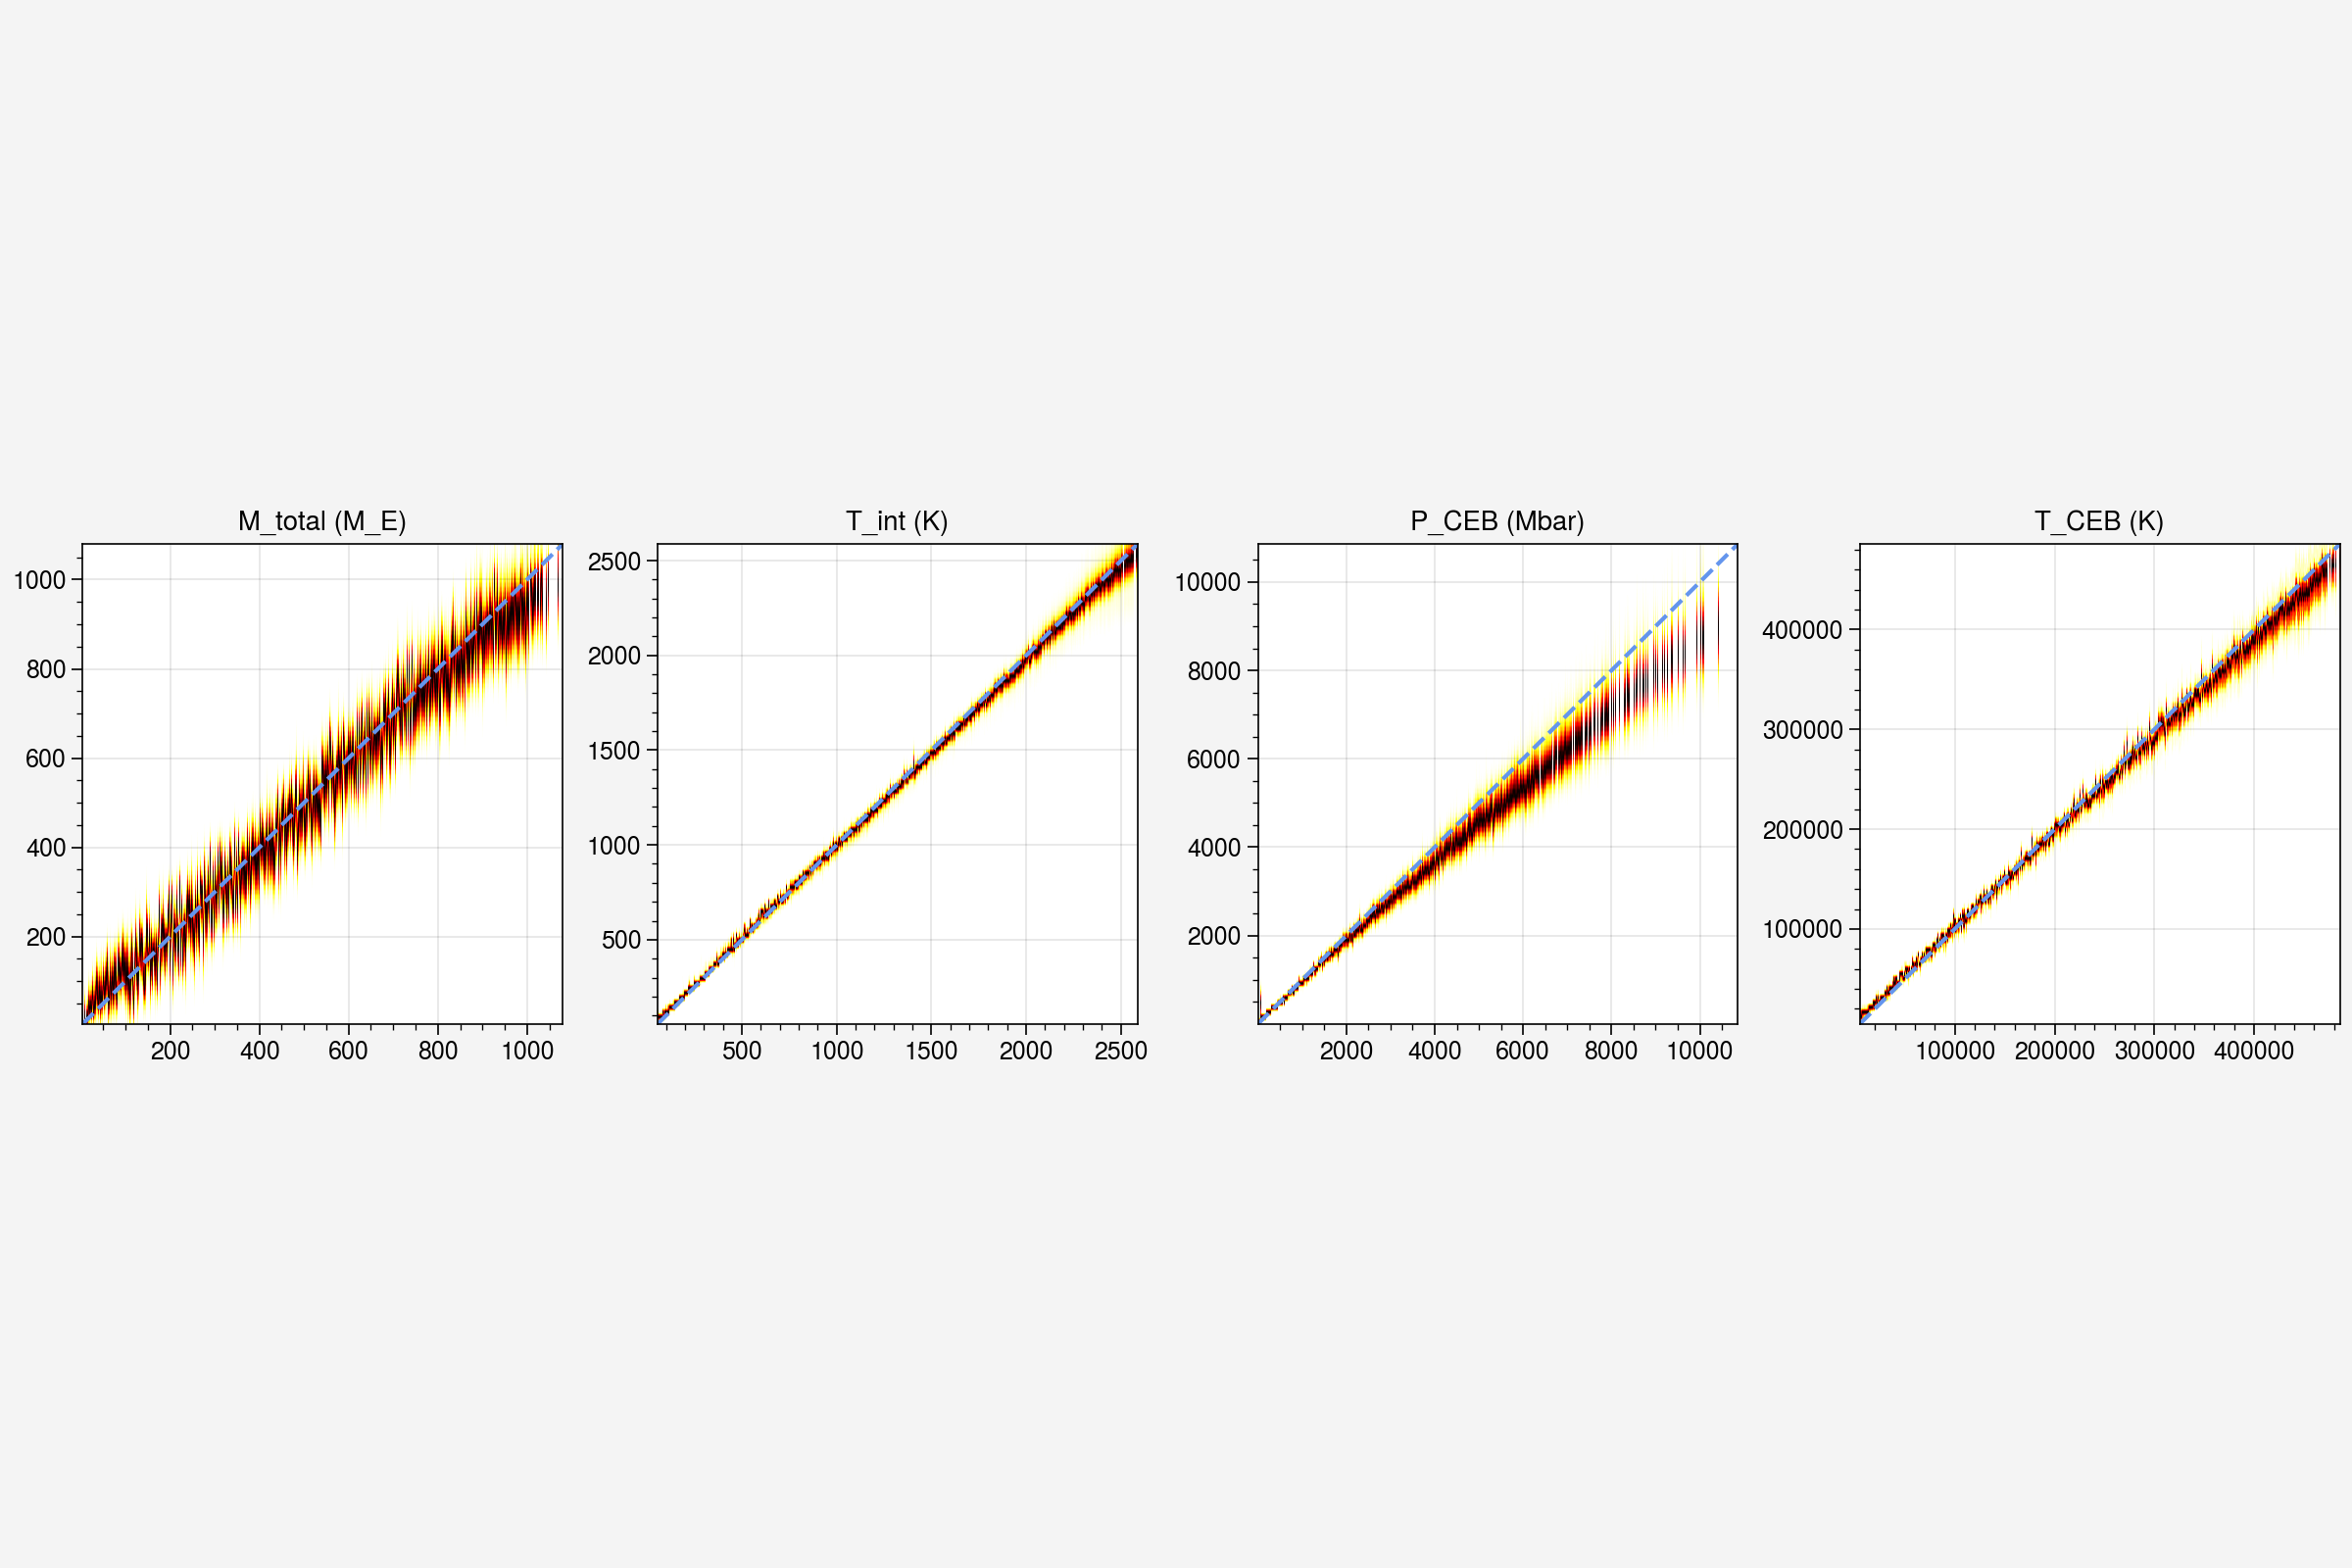

In [28]:
test_y_inverse = m_y.inverse_transform(y_test_scaled)
cmap = plt.cm.hot_r
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
fig, axs = pplt.subplots(
    #     figsize=(4,4),
    nrows=1, ncols=4,
    share=False,
    figsize=(12, 8)
    #     tight=True,
)

xlocators = [
    200, 500, 2000, 100000
]
xminorlocators = [
    0.004, 0.02, 0.02, 0.02, 40, 100, 0.04, 0.004
]

OUTPUT_DIMS = len(output_parameters)

for o in range(OUTPUT_DIMS):
    y_max = max(test_y_inverse[:, o])
    y_min = min(test_y_inverse[:, o])
    for i in range(0, GMM_PDF_scaled.shape[-1], OUTPUT_DIMS):
        tx, ty = [test_y_inverse[int(i / OUTPUT_DIMS), o], y_min]
        axs[o].imshow(
            GMM_PDF_scaled[:, o + i].reshape(-1, 1),
            cmap=cmap,
            norm=norm,
            origin='lower',
            extent=(tx, tx + 0.0001, ty, y_max)
        )

    axs[o].plot([y_min, y_max], [y_min, y_max], c='cornflowerblue', ls='--')
    axs[o].format(
        xlim=(y_min, y_max), ylim=(y_min, y_max), title=output_parameters[o],
        # xlabel=output_parameters[o], 
        xlocator=xlocators[o]
        # ylocator=xlocators[o], yminorlocator=xminorlocators[o]
    )

In [29]:
fig.save('D:\\PythonProject\\RebuildProject\\Rock\\imgs\\prediction_GasGiantExoplanetTensorflow_20240117.png')

In [48]:
col_dis = []
for o in range(len(output_parameters)):
    dis = 0
    for i in range(0, GMM_scaled.shape[-1], len(output_parameters)):
        test_y_current = y_test_scaled[int(i / len(output_parameters)), o]
        GMM_cal = GMM_scaled[:, o + i].reshape(-1, 1)
        offset = np.sqrt((GMM_cal - test_y_current) ** 2)
        dis += np.mean(offset)
    col_dis.append(dis / len(y_test_scaled))

In [49]:
col_dis

[0.3142055794111139,
 0.391226892523875,
 0.08537356524101579,
 0.3532803778863869]

In [39]:
test_y_inverse = m_y.inverse_transform(y_test_scaled)

In [40]:
col_dis = []
for o in range(len(output_parameters)):
    y_max = max(test_y_inverse[:, o])
    y_min = min(test_y_inverse[:, o])
    mean_dis = 0
    for i in range(0, GMM_scaled.shape[-1], len(output_parameters)):
        tx, ty = [test_y_inverse[int(i / len(output_parameters)), o], y_min]
        GMM_cal = GMM_scaled[:, o + i].reshape(-1, 1)
        dis = np.abs(np.mean(GMM_cal - tx) / np.sqrt(2))
        mean_dis += dis

    col_dis.append(mean_dis / len(test_y_inverse))
m_s = StandardScaler()
m_s.fit_transform(np.array(col_dis).reshape(-1, 1))

array([[-0.58295779],
       [-0.57340575],
       [-0.57567648],
       [ 1.73204002]])

In [25]:
s_y = MinMaxScaler()
s_y.fit_transform(np.array(col_dis).reshape(-1, 1))

array([[0.        ],
       [0.00412615],
       [0.00314528],
       [1.        ]])

In [41]:
col_dis

[233.80407408258856, 759.3378893700365, 634.4074170278092, 127600.2812615155]

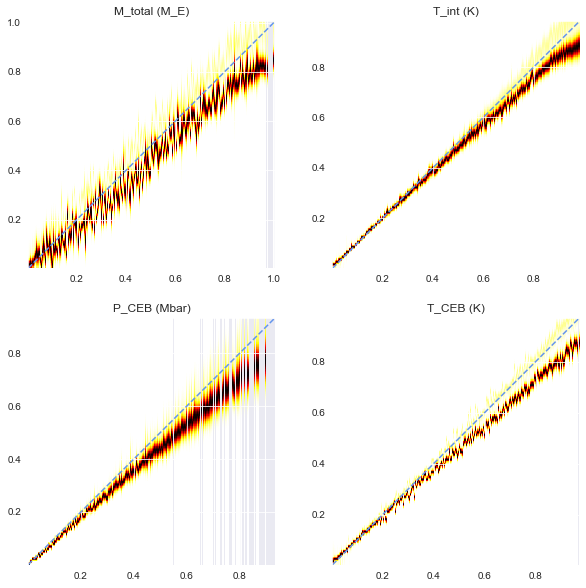

In [43]:
start = time.time()
y_label = np.arange(0,1,0.01).reshape(-1,1)
cmap = plt.cm.hot_r
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
fig = plt.figure(figsize=(10,10))
# fig.subplots_adjust(hspace=0.2, wspace=0.4)
# ax = plt.gca()
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
x_tickrange = [
    np.arange(0, 1100, 100),
    np.arange(100, 3600, 500),
#     np.arange(100, 2700, 100),
    np.arange(0, 14000, 2000),
    np.arange(0, 600000, 100000),
]
xminrange = [
    0,
    0,
    0,
    0
]
xmaxrange = [
    1000,
    3000,
    12000,
    500000
]

for img_num in range(OUTPUT_DIMS):
    ax = fig.add_subplot(2, 2, img_num+1)
    y_max = max(y_test_scaled[:, img_num])
    y_min = min(y_test_scaled[:, img_num])
    for c in range(len(y_test_scaled)):
        for m in range(OUTPUT_DIMS):
            locals()['mus'+str(m)] = []
            locals()['sigs'+str(m)] = []
            for n in range(20):
                locals()['mus'+str(m)].append(mus[c][n*OUTPUT_DIMS + m])
                locals()['sigs'+str(m)].append(sigs[c][n*OUTPUT_DIMS + m])
        i = img_num
        mus_ = np.array(locals()['mus'+str(i)])
        sigs_ = np.array(locals()['sigs'+str(i)])
        factors = 1 / math.sqrt(2*math.pi) / sigs_
        exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
        GMM_PDF = np.sum(pis[c]*factors*exponent, axis=1); # 对多个高斯分布求和
        MM = MinMaxScaler()
        GMM_PDF_scaled = MM.fit_transform(GMM_PDF.reshape(-1, 1))
        tx, ty = [y_test_scaled[c,i],y_min]
        ax.imshow(
            GMM_PDF_scaled.reshape(-1, 1),
            cmap=cmap,
            norm=norm,
            origin='lower',
            extent=(tx, tx + 0.0001, ty, y_max)
        )
    ax.plot([y_min, y_max], [y_min, y_max], c='cornflowerblue', ls='--')
    plt.axis('square')
    ax.set_xlim(y_min, y_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(output_parameters[img_num])

end = time.time()

In [44]:
end - start

40.90487766265869